In [0]:
import math
from datetime import *
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [0]:
PI = 3.14159
R = 6378.1 # radius of the earth in km
SECONDS_IN_A_DAY = 24 * 60 * 60
ORIGINAL_CSV_FILE = "./data.csv"

In [0]:
class Earthquake:
    
    """This class defines the concept of an earthquake for all subsequent uses in this project.
       An earthquake has three main attributes:
       timestamp : a datetime object that represents the time of occurence
       coordinates : a dict containing the latitude and longitude values 
       magnitude : a floating point value, the magnitude of the earthquake"""
    
    def __init__(self, timestamp, coordinates, magnitude):
        
        self.timestamp = timestamp
        self.coordinates = coordinates
        self.magnitude = magnitude
        
    def __str__(self):
        
        return "Timestamp \t\t Lat. \t\t Long. \t\t Magnitude \n{} \t {} \t {} \t{}".format(
                self.timestamp, 
                self.coordinates["latitude"], self.coordinates["longitude"], 
                self.magnitude)

In [0]:
def degrees_to_radians(deg):
    return (math.pi / 180) * deg

def spatial_distance(earthquake1, earthquake2):
    
    """calculates and returns the spatial distance in kms between two given earthquakes,
       using haversine formula"""

    coordinates1 = earthquake1.coordinates
    coordinates2 = earthquake2.coordinates
    
    latitude1 = degrees_to_radians(coordinates1["latitude"])
    latitude2 = degrees_to_radians(coordinates2["latitude"])

    longitude1 = degrees_to_radians(coordinates1["longitude"])
    longitude2 = degrees_to_radians(coordinates2["longitude"])

    delta_lat = latitude2 - latitude1
    delta_long = longitude2 - longitude1

    a = math.cos(latitude1) * math.cos(latitude2) * math.pow(math.sin(delta_long/2), 2) + math.pow(math.sin(delta_lat/2), 2)

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    d = R * c

    return d

In [0]:
def absolute_temporal_distance(earthquake1, earthquake2):
    
    """returns the absolute time difference in days between two given earthquakes"""
    
    timestamp1 = earthquake1.timestamp
    timestamp2 = earthquake2.timestamp
    
    duration = timestamp2 - timestamp1
    duration_in_seconds = duration.total_seconds()
    duration_in_days = duration_in_seconds / (SECONDS_IN_A_DAY)
    return abs(duration_in_days)

In [0]:
#EXAMPLE usage of the class Earthquake and the spatio-temporal distance functions

timestamp_example1 = datetime(1999, 4, 29, 20, 0, 1)
coordinates_example1 = {"latitude" : 24.323, "longitude" : 73.422}
magnitude_example1 = 9.5
earthquake_example1 = Earthquake(timestamp_example1, coordinates_example1, magnitude_example1)

timestamp_example2 = datetime(1999, 4, 28, 20, 2, 1)
coordinates_example2 = {"latitude" : 34.323, "longitude" : 93.422}
magnitude_example2 = 6.9
earthquake_example2 = Earthquake(timestamp_example2, coordinates_example2, magnitude_example2)

print(earthquake_example1)
print("\n")
print(earthquake_example2)
print("\n")
print("Spatial distance :", spatial_distance(earthquake_example1, earthquake_example2), "km")
print("Temporal distance :", absolute_temporal_distance(earthquake_example1, earthquake_example2), "days")

Timestamp 		 Lat. 		 Long. 		 Magnitude 
1999-04-29 20:00:01 	 24.323 	 73.422 	9.5


Timestamp 		 Lat. 		 Long. 		 Magnitude 
1999-04-28 20:02:01 	 34.323 	 93.422 	6.9


Spatial distance : 2231.409274019451 km
Temporal distance : 0.9986111111111111 days


In [0]:
def timestamp_from_string(date_, time_):
    
    """Takes as input two parameters:
    date_ : yyyy-mm-dd
    time_ : hh:mm:ss
    At present, it ignores the floating point part of the seconds value""" 
    
    tokens = date_.split("-")
    year = int(tokens[0])
    month = int(tokens[1])
    day = int(tokens[2])
    
    tokens = time_.split(":")
    hours = int(tokens[0])
    minutes = int(tokens[1])
    seconds = int(float(tokens[2]))
    
    return datetime(year, month, day, hours, minutes, seconds)

In [0]:
#EXAMPLE USAGE OF timestamp_from_string(date_, time_)

timestamp_example = timestamp_from_string("1999-04-29", "20:02:34.4")
print("Year: {} \nMonth: {} \nDay: {} \nHours: {} \nMinutes: {} \nSeconds: {}".format(
       timestamp_example.year, timestamp_example.month, timestamp_example.day,
       timestamp_example.hour, timestamp_example.minute, timestamp_example.second))

Year: 1999 
Month: 4 
Day: 29 
Hours: 20 
Minutes: 2 
Seconds: 34


In [0]:
def extract_from_csv(file):
    
    earthquakes = []
    with open(file) as f:
        data = csv.reader(f)

        for row in data:
            if row[0] == None:
                return earthquakes
#             print(row)
            if row[0] == "EVENT ID": #Skipping the first row
                continue
            datestring = row[2]
            timestring = row[3]
            latitude = row[4]
            longitude = row[5]
            magnitude = float(row[10])
            
            timestamp = timestamp_from_string(datestring, timestring)
            coordinates = {"latitude" : float(latitude), "longitude" : float(longitude)}
            
            earthquake = Earthquake(timestamp, coordinates, magnitude)
            
            earthquakes.append(earthquake)
        return earthquakes

In [0]:
"""Defining a spatio-temporal window for declustering"""
def spatial_window(earthquake):
    return math.exp(-1.024 + 0.804 * earthquake.magnitude)

def temporal_window(earthquake):
    return math.exp(-2.870 + 1.235 * earthquake.magnitude)

In [0]:
def is_dependent(shock, mainshock, spatial_radius, temporal_radius):
        return(spatial_distance(shock, mainshock) <= spatial_radius and
           absolute_temporal_distance(shock, mainshock) <= temporal_radius)    

In [0]:
def decluster_earthquakes(earthquakes):
    
    declustered_earthquakes = []
    
    while True:
        
        earthquakes.sort(key=lambda x : x.magnitude, reverse=True)
        
        mainshock = earthquakes[0]
        
        if(len(earthquakes) == 1):
            declustered_earthquakes.append(mainshock)
            return declustered_earthquakes
        
        spatial_radius = spatial_window(mainshock)
        temporal_radius = temporal_window(mainshock)
        
        for earthquake in earthquakes[1:]:
            
            if(is_dependent(earthquake, mainshock, spatial_radius, temporal_radius)):
               earthquakes.remove(earthquake)
                
        declustered_earthquakes.append(mainshock)
        earthquakes.remove(mainshock)
        
        if(earthquakes == []):
            return declustered_earthquakes

In [0]:
def find_interevent_times(earthquakes):
    
    """returns a list of interevent times in days"""
    
    intervent_times = []
    earthquakes.sort(key=lambda x : x.timestamp)
    l = len(earthquakes)
    
    print(len(earthquakes))
    for earthquake in earthquakes:
        print(earthquake)

    for prev_event, next_event in zip(earthquakes[:l-1], earthquakes[1:]):
        diff = absolute_temporal_distance(prev_event, next_event)
        intervent_times.append(diff)
    return(intervent_times)


In [0]:
earthquakes = extract_from_csv(ORIGINAL_CSV_FILE) # FIRST STEP IN WORKFLOW
print("Events found: {}".format(len(earthquakes)))
for earthquake in earthquakes :
    print(earthquake)

Events found: 86
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1905-04-04 00:49:59 	 32.6359 	 76.7878 	7.8
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1908-08-20 09:53:24 	 31.2276 	 87.8353 	6.9
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1911-10-14 23:23:59 	 30.7593 	 80.2794 	6.5
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1914-10-09 02:39:14 	 32.6041 	 76.1809 	6.2
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1915-12-03 02:39:24 	 27.6997 	 91.6401 	6.5
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1916-08-28 06:39:41 	 29.73 	 80.7454 	7.0
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1918-07-08 10:22:08 	 24.599 	 90.8528 	7.2
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1923-09-09 22:03:46 	 24.9372 	 90.7207 	6.9
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1924-10-08 20:32:55 	 30.8815 	 89.6514 	6.5
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1930-07-02 21:03:43 	 25.9288 	 90.1765 	7.2
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1934-01-15 08:43:25 	 26.8847 	 86.5885 	8.2
Timestamp 		 Lat. 		 Long. 		 Magnitude 

In [0]:
declustered_earthquakes = decluster_earthquakes(earthquakes) #SECOND STEP IN WORKFLOW
print("i.i.d. events found: {}".format(len(declustered_earthquakes)))
for earthquake in declustered_earthquakes:
    print(earthquake)

i.i.d. events found: 73
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1934-01-15 08:43:25 	 26.8847 	 86.5885 	8.2
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1905-04-04 00:49:59 	 32.6359 	 76.7878 	7.8
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1947-07-29 13:43:25 	 28.576 	 93.628 	7.8
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1951-11-18 09:35:54 	 31.0559 	 91.2612 	7.7
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1934-12-15 01:57:42 	 31.2496 	 89.162 	7.3
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1918-07-08 10:22:08 	 24.599 	 90.8528 	7.2
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1930-07-02 21:03:43 	 25.9288 	 90.1765 	7.2
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1943-10-23 17:23:21 	 26.6373 	 93.8518 	7.2
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1916-08-28 06:39:41 	 29.73 	 80.7454 	7.0
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1908-08-20 09:53:24 	 31.2276 	 87.8353 	6.9
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1923-09-09 22:03:46 	 24.9372 	 90.7207 	6.9
Timestamp 		 Lat. 		 Long. 		 Magnit

/home/ankit/.local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Magnitude')

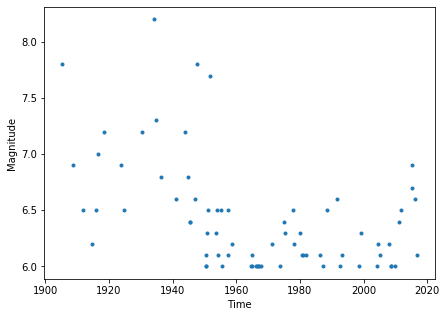

In [0]:
#THIRD STEP IN WORKFLOW: Plotting the data
fig = plt.figure()
fig.set_size_inches(7, 5)
plt.plot([earthquake.timestamp for earthquake in declustered_earthquakes], 
        [earthquake.magnitude for earthquake in declustered_earthquakes], '.')
plt.xlabel("Time")
plt.ylabel("Magnitude")

In [0]:
interevent_times = find_interevent_times(declustered_earthquakes) #STEP 4 in WORKFLOW

73
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1905-04-04 00:49:59 	 32.6359 	 76.7878 	7.8
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1908-08-20 09:53:24 	 31.2276 	 87.8353 	6.9
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1911-10-14 23:23:59 	 30.7593 	 80.2794 	6.5
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1914-10-09 02:39:14 	 32.6041 	 76.1809 	6.2
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1915-12-03 02:39:24 	 27.6997 	 91.6401 	6.5
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1916-08-28 06:39:41 	 29.73 	 80.7454 	7.0
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1918-07-08 10:22:08 	 24.599 	 90.8528 	7.2
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1923-09-09 22:03:46 	 24.9372 	 90.7207 	6.9
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1924-10-08 20:32:55 	 30.8815 	 89.6514 	6.5
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1930-07-02 21:03:43 	 25.9288 	 90.1765 	7.2
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1934-01-15 08:43:25 	 26.8847 	 86.5885 	8.2
Timestamp 		 Lat. 		 Long. 		 Magnitude 
1934-12-15 01

In [0]:
print(len(interevent_times))
print(interevent_times)

72
[1234.3773726851853, 1150.5629050925927, 1090.1355902777777, 420.00011574074074, 269.16686342592595, 679.1544791666666, 1889.4872453703704, 394.9369097222222, 2093.021388888889, 1292.4859027777777, 333.71825231481483, 529.1816319444445, 1700.265636574074, 1005.1955439814815, 360.0511111111111, 229.7305787037037, 18.244375, 597.4174768518518, 169.40372685185184, 1113.3326041666667, 1.1749421296296296, 9.19369212962963, 35.03875, 196.6749537037037, 217.4131712962963, 693.3140625, 52.90696759259259, 81.65722222222222, 339.43202546296294, 149.71631944444445, 656.8734375, 78.5128125, 483.63621527777775, 2159.582962962963, 25.93283564814815, 82.59938657407407, 417.53020833333335, 113.3508449074074, 172.42439814814816, 87.42070601851852, 185.1490625, 1345.3963657407407, 839.47375, 498.0252199074074, 105.88664351851853, 928.0009606481482, 136.8057638888889, 689.0988078703704, 158.4971875, 113.16815972222223, 429.94210648148146, 1608.9828356481482, 331.36188657407405, 460.88561342592595, 115

In [2]:
1234/31


39.806451612903224